# Convolutional Gaussian Processes
Mark van der Wilk (July 2019)

Here we show a simple example of the rectangles experiment, where we compare a normal squared exponential GP, and a convolutional GP. This is similar to the experiment in [1].

[1] Van der Wilk, Rasmussen, Hensman (2017). Convolutional Gaussian Processes. *Advances in Neural Information Processing Systems 30*.

## Generate dataset
Generate a simple dataset of rectangles. We want to classify whether they are tall or wide. **NOTE:** Here we take care to make sure that the rectangles don't touch the edge, which is different to the original paper. We do this to avoid needing to use patch weights, which are needed to correctly account for edge effects.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")

def is_continuous_integration():
    return os.environ.get('CI', None) is not None

MAXITER = 2 if is_continuous_integration() else 100
NUM_TRAIN_DATA = 5 if is_continuous_integration() else 100  # This is less than in the original rectangles dataset
NUM_TEST_DATA = 7 if is_continuous_integration() else 300

In [2]:
def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0:x1+1] = 1
    
def make_random_rectangle(arr):
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1
    
def make_rectangles_dataset(num, w, h):
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return d.reshape(num, w * h).astype(gpflow.config.default_float()), Y.astype(gpflow.config.default_float())

In [3]:
X, Y = data = make_rectangles_dataset(NUM_TRAIN_DATA, 28, 28)
Xt, Yt = test_data = make_rectangles_dataset(NUM_TEST_DATA, 28, 28)

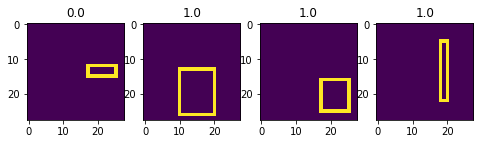

In [4]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(28, 28))
    plt.title(Y[i, 0])

## Squared Exponential kernel

In [5]:
rbf_m = gpflow.models.SVGP(gpflow.kernels.SquaredExponential(), gpflow.likelihoods.Bernoulli(),
                           gpflow.inducing_variables.InducingPoints(X.copy()))

In [6]:
rbf_m_log_likelihood = rbf_m.log_likelihood
print("RBF elbo before training: %.4e" % rbf_m_log_likelihood(data))
rbf_m_log_likelihood = tf.function(rbf_m_log_likelihood, autograph=False)

RBF elbo before training: -4.9704e+00


In [7]:
gpflow.utilities.set_trainable(rbf_m.inducing_variable, False)
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    lambda: -rbf_m_log_likelihood(data),
    variables=rbf_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER})
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


3.715 iter/s


In [8]:
train_err = np.mean((rbf_m.predict_y(X)[0] > 0.5).numpy().astype('float') == Y)
test_err = np.mean((rbf_m.predict_y(Xt)[0] > 0.5).numpy().astype('float') == Yt)
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")
print("RBF elbo after training: %.4e" % rbf_m_log_likelihood(data))

Train acc: 100.0%
Test acc : 28.57142857142857%


RBF elbo after training: -3.4740e+00


## Convolutional kernel

In [9]:
f64 = lambda x: np.array(x, dtype=np.float64)
positive_with_min = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4))(tfp.bijectors.Softplus())
constrained = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4), scale=f64(100.0))(tfp.bijectors.Sigmoid())
max_abs_1 = lambda: tfp.bijectors.AffineScalar(shift=f64(-2.0), scale=f64(4.0))(tfp.bijectors.Sigmoid())

conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), [28, 28], [3, 3])
conv_k.basekern.lengthscale = gpflow.Parameter(1.0, transform=positive_with_min())
# Weight scale and variance are non-identifiable. We also need to prevent variance from shooting off crazily.
conv_k.basekern.variance = gpflow.Parameter(1.0, transform=constrained())
conv_k.weights = gpflow.Parameter(conv_k.weights.numpy(), transform=max_abs_1())
conv_f = gpflow.inducing_variables.InducingPatches(np.unique(conv_k.get_patches(X).numpy().reshape(-1, 9), axis=0))

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [10]:
conv_m = gpflow.models.SVGP(conv_k, gpflow.likelihoods.Bernoulli(), conv_f)

In [11]:
gpflow.utilities.set_trainable(conv_m.inducing_variable, False)
conv_m.kernel.basekern.variance.trainable = False
conv_m.kernel.weights.trainable = False

In [12]:
conv_m_log_likelihood = conv_m.log_likelihood
print("conv elbo before training: %.4e" % conv_m_log_likelihood(data))
conv_m_log_likelihood = tf.function(conv_m_log_likelihood, autograph=False)

conv elbo before training: -4.6561e+00


In [13]:
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    lambda: -conv_m_log_likelihood(data),
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER / 10})
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


1.672 iter/s


In [14]:
conv_m.kernel.basekern.variance.trainable = True
res = gpflow.optimizers.Scipy().minimize(
    lambda: -conv_m.log_likelihood(data),
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER})
train_err = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype('float') == Y)
test_err = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype('float') == Yt)
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")
print("conv elbo after training: %.4e" % conv_m_log_likelihood(data))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Train acc: 80.0%
Test acc : 57.14285714285714%


conv elbo after training: -3.4209e+00


In [15]:
res = gpflow.optimizers.Scipy().minimize(
    lambda: -conv_m.log_likelihood(data),
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER})
train_err = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype('float') == Y)
test_err = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype('float') == Yt)
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")
print("conv elbo after training: %.4e" % conv_m_log_likelihood(data))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Train acc: 80.0%
Test acc : 57.14285714285714%
conv elbo after training: -3.4034e+00


In [16]:
conv_m.kernel.weights.trainable = True
res = gpflow.optimizers.Scipy().minimize(
    lambda: -conv_m.log_likelihood(data),
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER})
train_err = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype('float') == Y)
test_err = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype('float') == Yt)
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")
print("conv elbo after training: %.4e" % conv_m_log_likelihood(data))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


Train acc: 80.0%
Test acc : 57.14285714285714%
conv elbo after training: -3.3941e+00


In [17]:
gpflow.utilities.print_summary(rbf_m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.7567074450840591
SVGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.9999999999881266
SVGP.inducing_variable.Z,Parameter,,,False,"(5, 784)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,,,True,"(5, 1)",float64,[[-0.48861799...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 5, 5)",float64,"[[[8.41645245e-01, 0.00000000e+00, 0.00000000e+00..."


In [18]:
gpflow.utilities.print_summary(conv_m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.basekern.variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,0.7865689214574055
SVGP.kernel.basekern.lengthscale,Parameter,Softplus + AffineScalar,,True,(),float64,0.989636923107222
SVGP.kernel.weights,Parameter,Sigmoid + AffineScalar,,True,"(676,)",float64,"[0.99990223, 0.99990223, 0.99990223..."
SVGP.inducing_variable.Z,Parameter,,,False,"(40, 9)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,,,True,"(40, 1)",float64,[[6.74046904e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 40, 40)",float64,"[[[6.22466044e-01, 0.00000000e+00, 0.00000000e+00..."


## Conclusion
The convolutional kernel performs much better in this simple task. It demonstrates non-local generalization of the strong assumptions in the kernel.